In [8]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

# Import necessary libraries and functions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.utils import (
    preprocess_mat_data,
    short_term_fourier_transform_stft,
    plot_stft_results,
    preprocess_and_reduce,
    find_optimal_clusters,
    apply_MiniBatchKMeans,
    identify_anomalies_kmeans,
    plot_clusters_and_anomalies_kmeans,
    identify_anomalies_distance,
    plot_clusters_and_anomalies_distance,
    save_anomalies_to_csv,
)
from src.load_config import LoadConfig

# Load configuration
APPCFG = LoadConfig()

# Display the selected file path and acceleration parameter for debugging
print(f"Selected file: {APPCFG.mat_data}")
print(f"Acceleration to analyze: {APPCFG.acceleration_to_analyze}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Selected file: /mnt/g/My Drive/UPV/signals_track_maintenance/data/Datos_Matlab/Datos_210509-104818_RA_AP.mat
Acceleration to analyze: acc_vert_right_axle_box_ms2


[2024-11-05T14:26:24+0000] [INFO] [294] [utils] Number of samples: 156200
[2024-11-05T14:26:24+0000] [INFO] [298] [utils] Total time: [38907.   38907.01 38907.02 ... 40468.97 40468.98 40468.99]
[2024-11-05T14:26:24+0000] [INFO] [304] [utils] Window samples: 25
[2024-11-05T14:26:24+0000] [INFO] [312] [utils] Overlap: 23


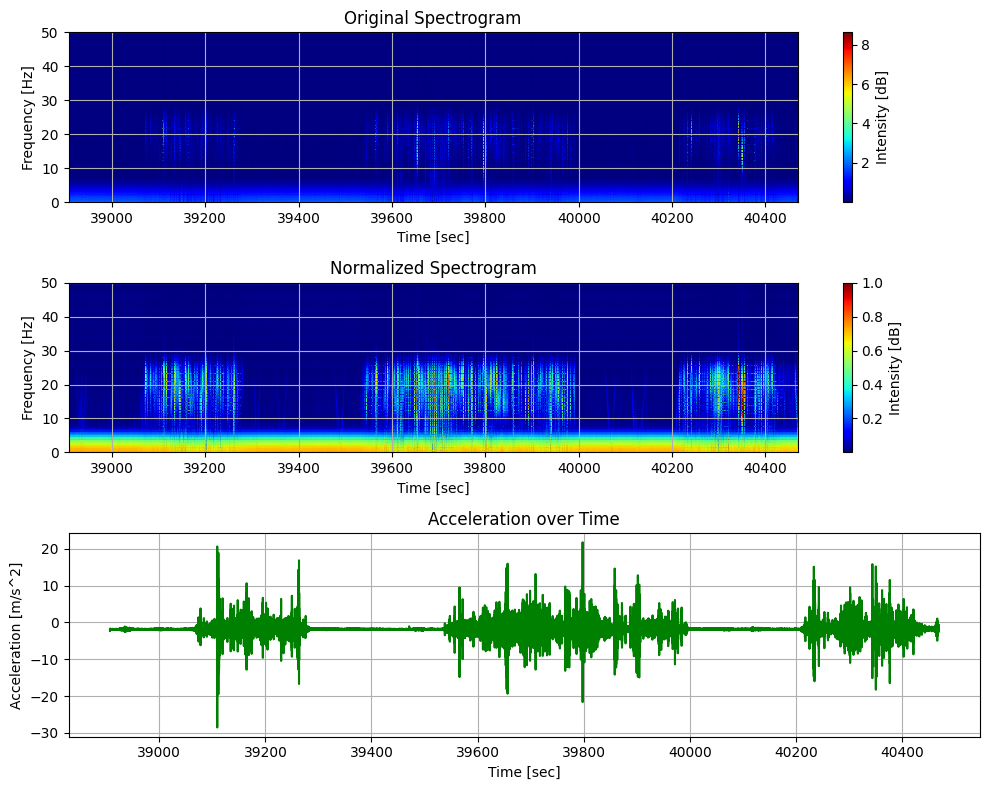

In [9]:
# Aquí se utiliza la función preprocess_mat_data para cargar y preprocesar los datos desde un archivo .mat.
# Extrae la señal de aceleración y la columna de tiempo, además de devolver un DataFrame con los datos.

(
    data_f20_10,
    signal_acc_mat,
    time_column_mat,
    kilometer_ref,
    df_mat,
) = preprocess_mat_data(
    data_path=APPCFG.mat_data,
    acel_to_process=APPCFG.acceleration_to_analyze,
    time_col_name="timestamp_s",
    km_ref_col_name="kilometer_ref_fixed_km",
)


# Apply STFT
(
    frequencies_acc,
    times_acc,
    magnitude_spectrogram_acc,
    X_prime_acc,
    total_time_acc,
) = short_term_fourier_transform_stft(
    signal=signal_acc_mat,
    sampling_frequency_stft=APPCFG.sampling_frequency_stft_prepared,
    window_length=APPCFG.window_length,
    overlap=APPCFG.overlap,
    gamma=APPCFG.gamma,
    time_column=time_column_mat,
    nfft=APPCFG.nfft_prepared,
)


plot_stft_results(
    frequencies_acc,
    times_acc,
    magnitude_spectrogram_acc,
    X_prime_acc,
    total_time_acc,
    signal_acc_mat,
    # save_path=APPCFG.get_anomalies_filename("stft", file_extension="png"),
)

In [3]:
# data_f20_10 from numpy array to pandas dataframe
column_names = [
    "acc_long_veh_ms2",
    "acc_lat_veh_ms2",
    "acc_vert_veh_ms2",
    "speed_raw_kmh",
    "acc_vert_left_axle_box_ms2",  #! IMPORTANT
    "acc_vert_right_axle_box_ms2",  #! IMPORTANT
    "acc_lat_axle_box_ms2",  #! IMPORTANT
    "acc_lat_bogie_ms2",
    "timestamp_s",
    "distance_travelled_m",
    "kilometer_ref_no_fixed_km",
    "kilometer_ref_fixed_km",
]
data_f20_10_df = pd.DataFrame(data_f20_10["f20_10"][0], columns=column_names)

display(data_f20_10_df.describe())

display(data_f20_10_df.head())

,acc_long_veh_ms2,acc_lat_veh_ms2,acc_vert_veh_ms2,speed_raw_kmh,acc_vert_left_axle_box_ms2,acc_vert_right_axle_box_ms2,acc_lat_axle_box_ms2,acc_lat_bogie_ms2,timestamp_s,distance_travelled_m,kilometer_ref_no_fixed_km,kilometer_ref_fixed_km
count,156200.000000,156200.000000,156200.000000,156200.000000,156200.000000,156200.000000,156200.000000,156200.000000,156200.000000,156200.000000,156200.000000,156200.000000
mean,-0.020454,-0.005691,9.866447,23.285734,-2.843528,-1.727625,-0.119964,-0.306903,39708.440583,3.009262,4.339852,4.360576
std,0.789638,0.773336,1.010081,23.873650,1.131298,1.058220,0.106244,0.195018,463.777162,2.452678,3.121553,3.149243
min,-31.455364,-31.510110,-31.359063,0.000000,-39.253786,-28.505295,-1.626290,-2.316686,38907.000000,0.000000,0.069986,0.069986
25%,-0.032702,-0.006976,9.866052,0.000000,-3.052338,-1.920143,-0.138272,-0.327401,39297.497500,0.667217,2.042998,2.042986
50%,0.011999,0.014101,9.892649,18.925954,-2.919315,-1.807783,-0.129031,-0.314415,39719.995000,1.997880,3.865965,3.885232
75%,0.046134,0.031096,9.909739,43.429685,-2.653835,-1.559384,-0.104015,-0.286421,40110.492500,5.238653,7.281648,7.337012
max,2.024660,2.411167,12.131701,77.102528,35.978234,21.776488,1.301631,2.045278,40500.990000,8.105536,10.148531,10.203895


,acc_long_veh_ms2,acc_lat_veh_ms2,acc_vert_veh_ms2,speed_raw_kmh,acc_vert_left_axle_box_ms2,acc_vert_right_axle_box_ms2,acc_lat_axle_box_ms2,acc_lat_bogie_ms2,timestamp_s,distance_travelled_m,kilometer_ref_no_fixed_km,kilometer_ref_fixed_km
0,-0.004008,-0.008478,9.867072,0.433223,-3.245438,-2.293805,-0.175898,-0.291258,38907.00,0.000000e+00,0.069986,0.069986
1,-0.001098,0.005070,9.885333,0.257798,-3.011579,-1.927766,-0.157099,-0.305332,38907.01,9.597513e-07,0.069987,0.069987
2,0.001512,0.016457,9.895775,0.107587,-2.919150,-1.706711,-0.140287,-0.317214,38907.02,1.467230e-06,0.069987,0.069987
3,0.003379,0.024407,9.897780,0.000000,-2.933584,-1.682768,-0.127684,-0.325426,38907.03,1.616657e-06,0.069987,0.069987
4,0.004336,0.028643,9.895605,0.000000,-2.952979,-1.784335,-0.120138,-0.329621,38907.04,1.616657e-06,0.069987,0.069987


In [4]:
# Aqui se muestra información sobre el arreglo de tiempo de la Transformada de Fourier de Corto Plazo (STFT),
# incluyendo su forma, rango de tiempo completo, número de puntos de tiempo y el rango de tiempo de la señal original.

print(f"Shape of STFT time array: {times_acc.shape}")
print(f"Full time range: {times_acc.min()} to {times_acc.max()}")
print(f"Number of time points: {len(times_acc)}")
print(
    f"Time range of original signal: {time_column_mat.min()} to {time_column_mat.max()}"
)

Shape of STFT time array: (78101,)
Full time range: 38907.0 to 40469.0
Number of time points: 78101
Time range of original signal: 38907.0 to 40500.99


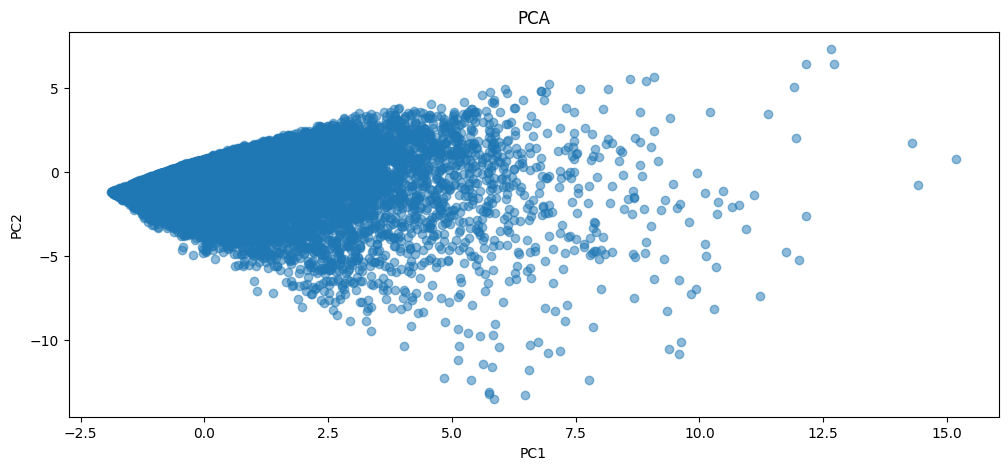

In [5]:
#  Aquí se utiliza la función preprocess_and_reduce para reducir la dimensionalidad del espectrograma de magnitud utilizando PCA.
# Luego, se visualizan los resultados de PCA en un gráfico de dispersión.

# Preprocess and reduce dimensionality
reduced_features_scaled = preprocess_and_reduce(
    magnitude_spectrogram_acc, n_components=10
)

# Plot PCA and SVD results
plt.figure(figsize=(12, 5))
plt.scatter(reduced_features_scaled[:, 0], reduced_features_scaled[:, 1], alpha=0.5)
plt.title("PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [6]:
1 / 0

ZeroDivisionError: division by zero

[2024-10-31T13:27:01+0000] [INFO] [495] [utils] Optimal number of clusters: 7


Optimal number of clusters: 7


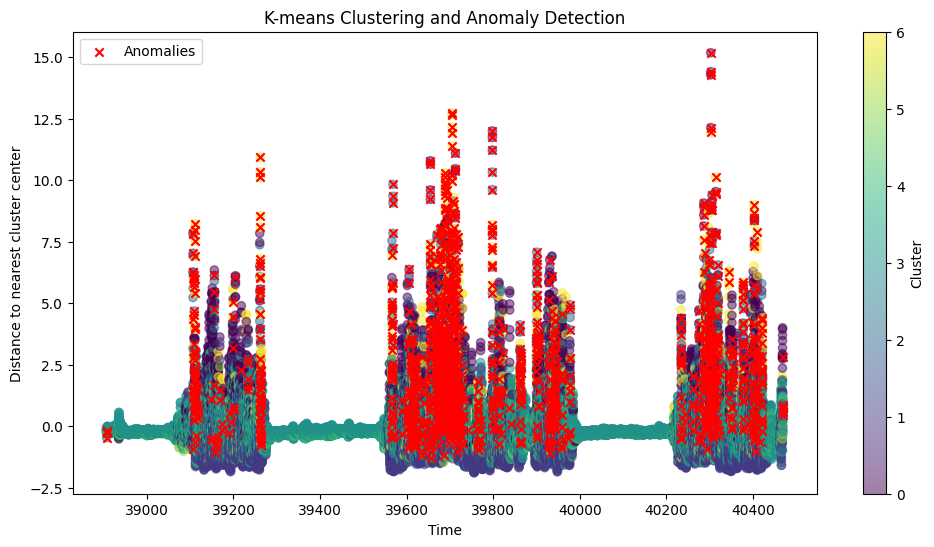

[2024-10-31T13:27:02+0000] [INFO] [766] [utils] Anomalies saved to /mnt/g/My Drive/UPV/signals_track_maintenance/data/output/RA_AP/RA_AP_acc_lat_axle_box_ms2_anomalies_kmeans.csv


In [21]:
# Aquí se determina el número óptimo de clústeres utilizando el método del codo.
# Luego, se aplica el algoritmo MiniBatchKMeans para agrupar los datos reducidos y se identifican las anomalías.
# Finalmente, se visualizan los resultados de agrupamiento y se guardan las anomalías en un archivo CSV.

# En la función identify_anomalies_kmeans, la distancia a la que se refiere es la distancia euclidiana entre cada punto de datos y el centro del clúster más cercano.
# Esta distancia se calcula en el espacio de características de los datos reducidos (por ejemplo, después de aplicar PCA).
# Por lo tanto, los valores en el eje Y del gráfico "Distance to nearest cluster center" representan la distancia euclidiana
# en el espacio de características, que es una medida abstracta y no tiene unidades físicas.

# Find optimal number of clusters
max_k = 10
optimal_k = find_optimal_clusters(
    reduced_features_scaled,
    max_k,
    save_path=APPCFG.get_anomalies_filename("optimal_clusters", file_extension="png"),
)
print(f"Optimal number of clusters: {optimal_k}")

# Apply K-means clustering
mbkmeans, labels = apply_MiniBatchKMeans(reduced_features_scaled, optimal_k)

# Identify anomalies using K-means
anomalies_kmeans = identify_anomalies_kmeans(
    reduced_features_scaled, mbkmeans, percentile=APPCFG.percentile_kmeans
)

# Plot clustering results with anomalies
plot_clusters_and_anomalies_kmeans(
    times_acc,
    reduced_features_scaled,
    labels,
    anomalies_kmeans,
    # save_path=APPCFG.get_anomalies_filename("kmeans", file_extension="png"),
)

# Save K-means anomalies to CSV
save_anomalies_to_csv(
    anomalies_kmeans,
    times_acc,
    frequencies_acc,
    kilometer_ref,
    APPCFG.get_anomalies_filename("kmeans"),
)

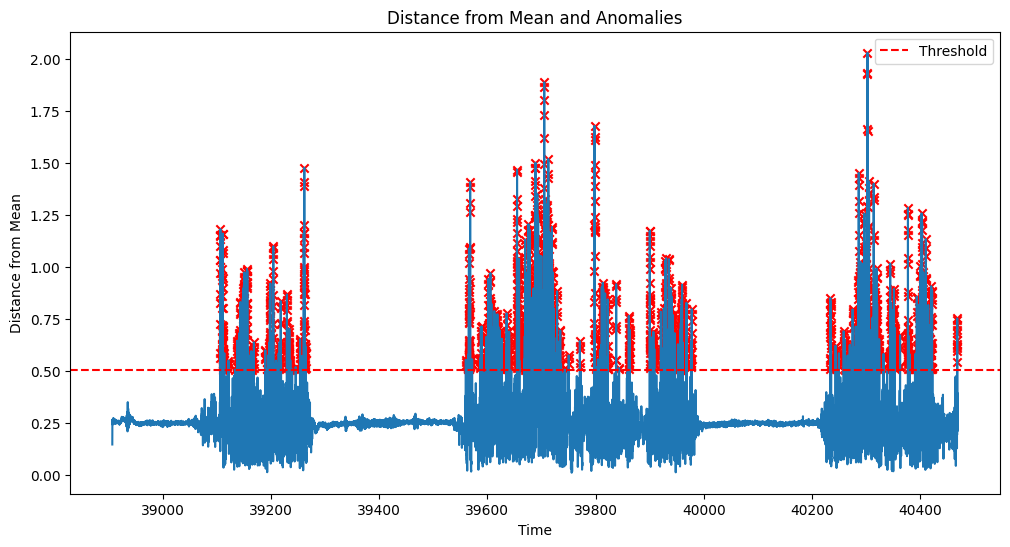

[2024-10-31T13:22:25+0000] [INFO] [701] [utils] Anomalies saved to /mnt/g/My Drive/UPV/signals_track_maintenance/data/output/RA_AP/RA_AP_acc_lat_axle_box_ms2_anomalies_distance.csv


In [10]:
# Aquí se identifican anomalías basadas en la distancia desde el espectro medio utilizando la función identify_anomalies_distance.
# Luego, se visualizan las anomalías detectadas y se guardan en un archivo CSV.

# En la función identify_anomalies_distance, la distancia desde el espectro medio se calcula utilizando la norma euclidiana.
# Esto significa que se mide cuán lejos está cada punto de datos del promedio de todos los puntos en el espacio de características.
# Al igual que en el caso anterior, los valores en el eje Y del gráfico "Distance from Mean" son distancias euclidianas en el espacio de características, y no tienen unidades físicas.

# Identify anomalies using distance from mean
distances_from_mean, threshold, anomalies_distance = identify_anomalies_distance(
    magnitude_spectrogram_acc
)

# Plot anomalies detected by distance from mean
plot_clusters_and_anomalies_distance(
    times_acc,
    anomalies_distance,
    distances_from_mean,
    threshold,
    # save_path=APPCFG.get_anomalies_filename("distance", file_extension="png"),
)
# Save distance-based anomalies to CSV
save_anomalies_to_csv(
    anomalies_distance,
    times_acc,
    frequencies_acc,
    kilometer_ref,
    APPCFG.get_anomalies_filename("distance"),
)

In [11]:
#  Aquí se muestra un resumen de los puntos de datos totales, el número y porcentaje de anomalías detectadas por K-means y por distancia desde el medio,
#  así como los rangos de tiempo correspondientes para ambas detecciones de anomalías.


# Print summary
print(f"Total data points: {len(reduced_features_scaled)}")
print(
    f"Anomalies detected by K-means: {np.sum(anomalies_kmeans)}, Percentage: {np.round(np.sum(anomalies_kmeans)/len(times_acc)*100, 2)}%"
)
print(
    f"K-means time range: {times_acc[np.where(anomalies_kmeans)[0]].min()} to {times_acc[np.where(anomalies_kmeans)[0]].max()}"
)
print(
    f"Anomalies detected by distance from mean: {np.sum(anomalies_distance)}, Percentage: {np.round(np.sum(anomalies_distance)/len(times_acc)*100, 2)}%"
)
print(
    f"Distance from mean time range: {times_acc[np.where(anomalies_distance)[0]].min()} to {times_acc[np.where(anomalies_distance)[0]].max()}"
)

Total data points: 78101
Anomalies detected by K-means: 1562, Percentage: 2.0%
K-means time range: 38907.0 to 40469.0
Anomalies detected by distance from mean: 3327, Percentage: 4.26%
Distance from mean time range: 39106.6 to 40468.1
